<a href="https://colab.research.google.com/github/MBENALLA/sma_crossover/blob/main/MA_Crossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install python-binance
import pandas as pd
from binance.client import Client
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt

In [4]:
client = Client()

In [5]:
def get_data(coin, lookback):
    df = pd.DataFrame(client.get_historical_klines(coin,
                                                   Client.KLINE_INTERVAL_5MINUTE,
                                                   str(lookback) + ' days ago UTC'))
    closes = pd.DataFrame(df[4])
    closes.columns = ['Close']
    closes.Close = closes.Close.astype(float)
    return closes

In [7]:
engine = create_engine('sqlite:///backtest_db.db')
#engine.execute("DELETE FROM DOTUSDT")
get_data('DOTUSDT', 1).to_sql('DOTUSDT', engine, if_exists='append', index=False)
data = pd.read_sql('DOTUSDT', engine)

In [8]:
def storming(df):
    df = df.copy()
    df['Short_ma'] = df.Close.rolling(5).mean()
    df['Long_ma'] = df.Close.rolling(13).mean()
    df['In_position'] = np.where(df['Short_ma'] > df['Long_ma'], 1, 0)
    df['R_position'] = df['In_position'].diff() * df['Close']
    df.dropna(inplace=True)
    return df



In [9]:
def real_value(df):
    df1 = storming(df)[storming(df).R_position != 0]
    df1['ROC'] = np.absolute(df1.R_position).pct_change() * df1.In_position.shift(1)
    df1 = df1[np.absolute(df1.ROC) != 0]
    df1.dropna(inplace=True)
    nb_trades = len(df1)
    performance = df1.ROC.sum()
    return round(performance, 5), nb_trades

0.00926 9 0.0135
-0.42400000000000004 %


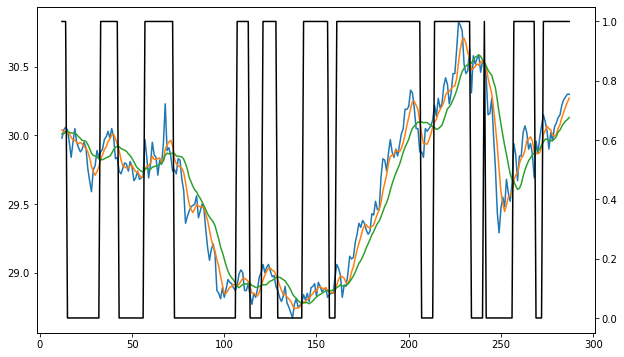

In [10]:
perf, nb_trade = real_value(data)

trading_fees = nb_trade * 2 * 0.00075
print(perf, nb_trade, round(trading_fees, 5))
print((perf-trading_fees)*100, '%')
df2 = storming(data)


fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(df2[['Close', 'Short_ma', 'Long_ma']])
ax2.plot(df2['In_position'], color='black')
plt.show()